
# Project Description

Churn prediction is the process of determining which customers are likely to stop doing business with a company. This is achieved by analyzing customer data, such as usage patterns and demographics, to create predictive models. Churn prediction is invaluable to businesses because it allows them to address customer concerns ahead of time, implement targeted retention strategies, and reduce revenue loss. Understanding the factors that contribute to customer churn allows businesses to improve customer satisfaction, strengthen relationships, and, ultimately, increase customer lifetime value. In this project, I will create a churn prediction model  on a [Kaggle dataset](https://www.kaggle.com/datasets/shubh0799/churn-modelling/data) using both supervised and reinforcement learning methods. I will also use unsupervised learning to segment customers and provide a dashboard with a summary of my findings.

Author: Ahmad Mustapha Wali, Gen. AI / DS Group (Advanced)


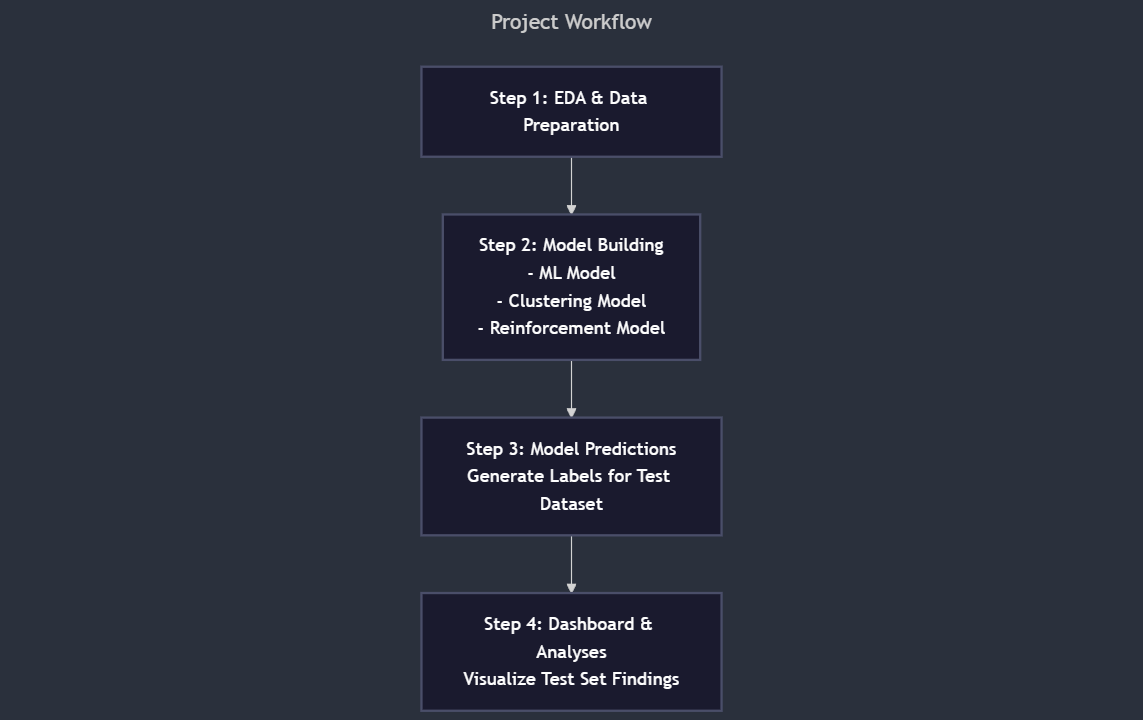

In [1]:
import pandas as pd

from helper import (
    ChurnDataProcessor,
    XGBoostChurnClassifier,
    ChurnKMeansClustering,
    train_rl_churn_model
)

from utils import EDA, create_dashboard

# EDA and Data Preparation

In [2]:
# Create an instance of the EDA class
eda = EDA('Churn_Modelling.csv')

# Example usage of EDA methods
eda.overview()

Dataset Shape: (10000, 14)
Dataset Types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


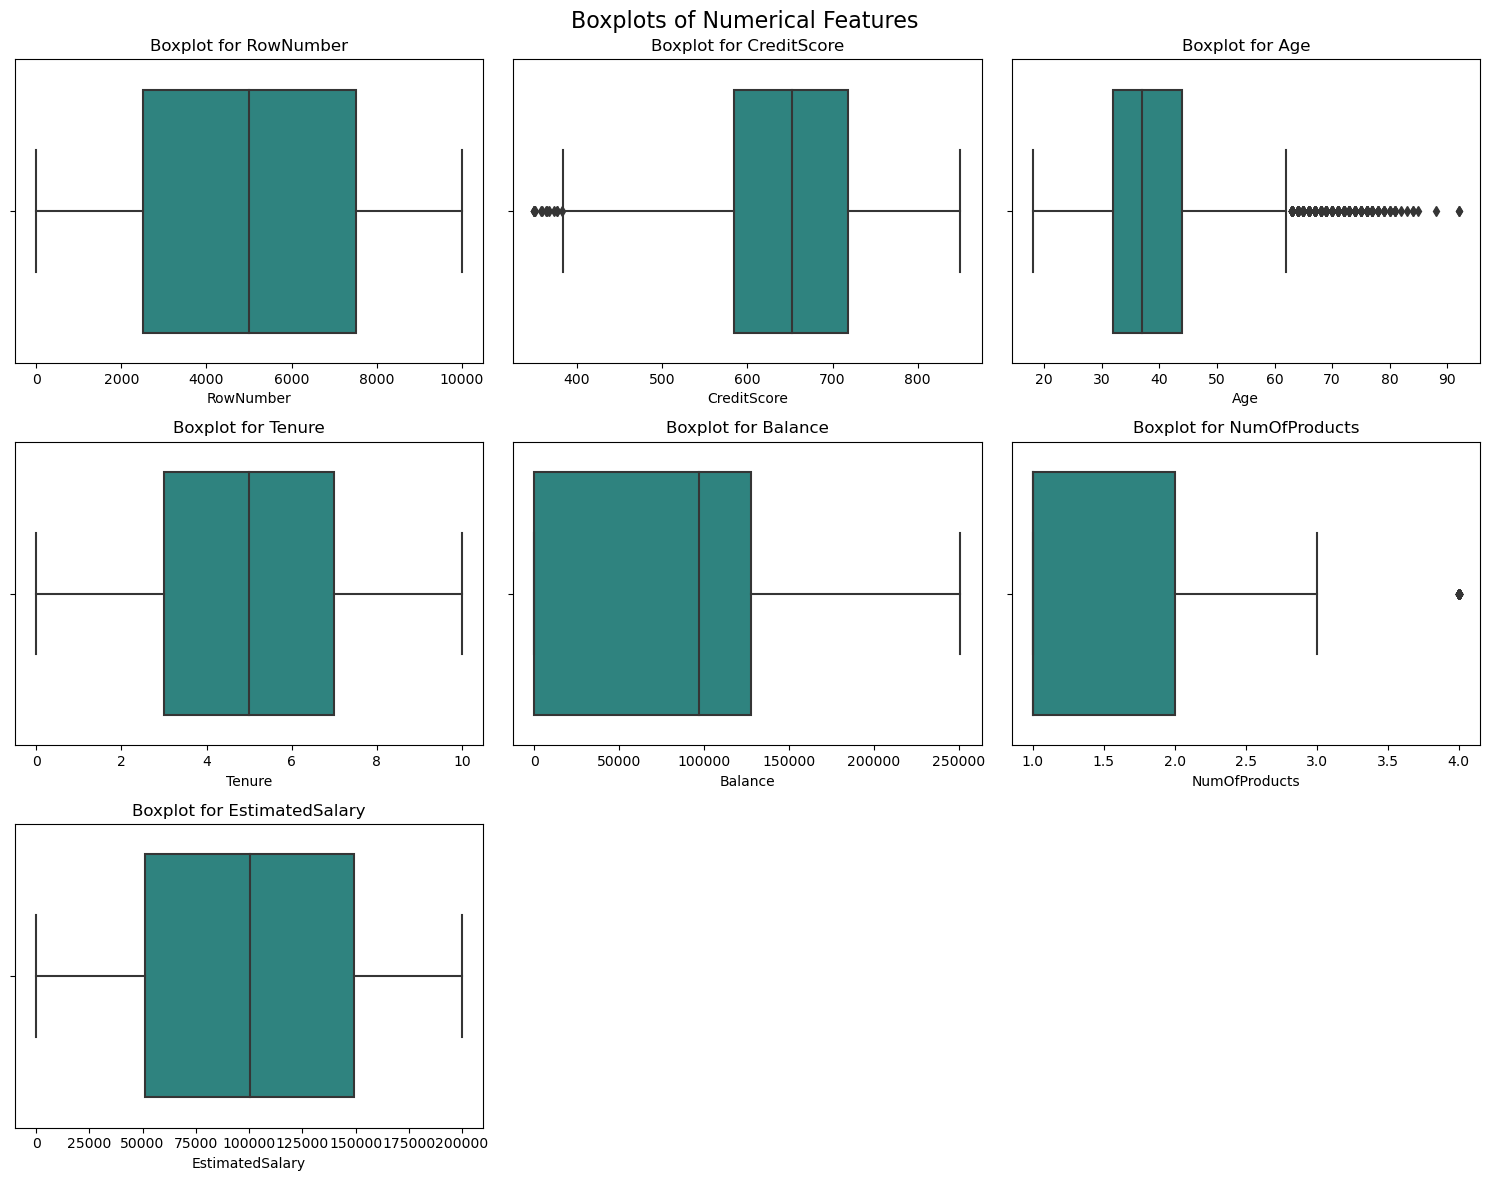

In [3]:
# Observe feature distributions
eda.plot_feature_boxplots()

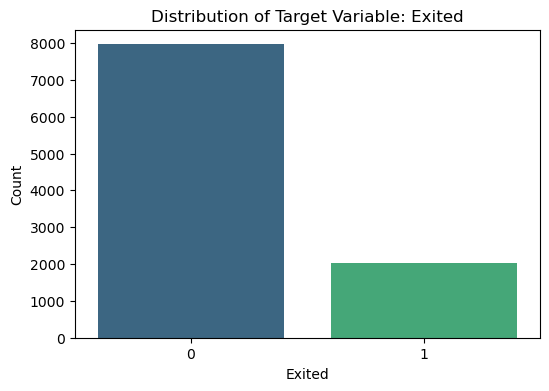

In [4]:
# Observe the distribusions of the target variable
eda.plot_target_distribution(target_column='Exited')

In [5]:
# Visualize statistical description of the dataset
description_df = eda.show_description()
description_df

Statistical Description of the Dataset:


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Find missing values
eda.show_missing_values()

No missing values found in the dataset.


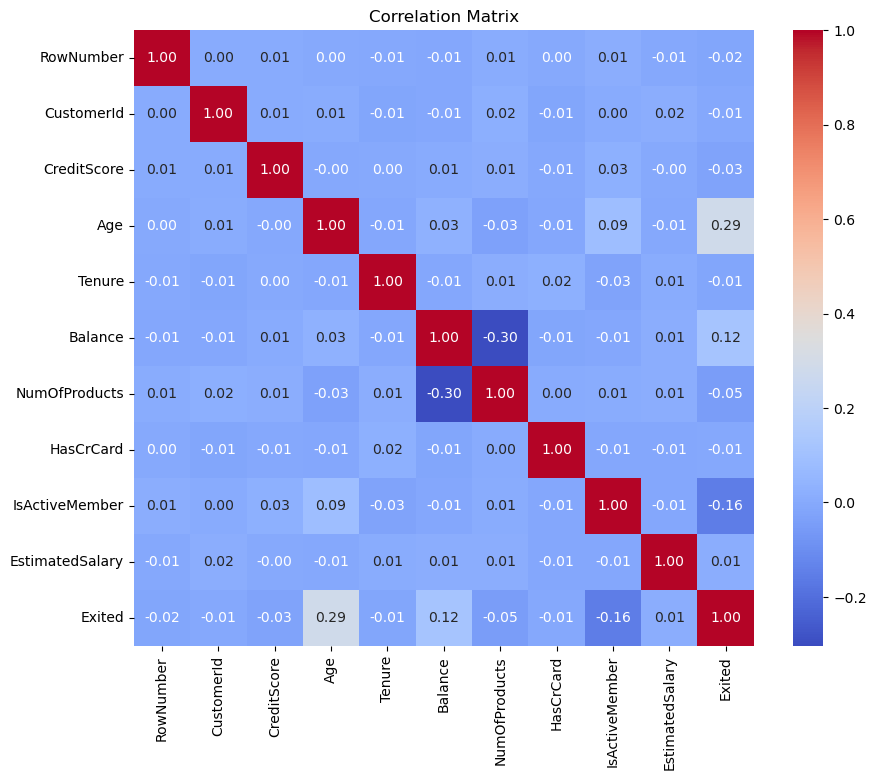

In [7]:
# Display correlation matrix
eda.explore_correlation()

In [8]:
# Explore dataset cardinality
eda.explore_high_cardinality_columns(threshold=50)

Columns with more than 50 unique values:
RowNumber: 10000 unique values
CustomerId: 10000 unique values
Surname: 2932 unique values
CreditScore: 460 unique values
Age: 70 unique values
Balance: 6382 unique values
EstimatedSalary: 9999 unique values


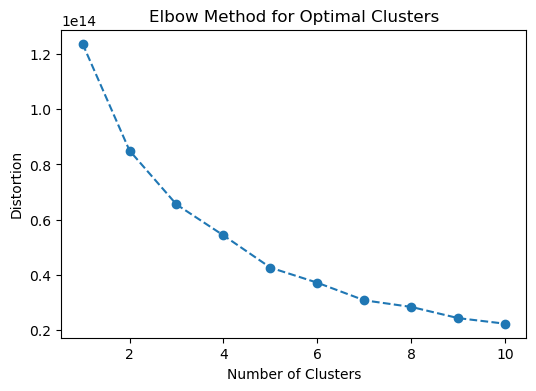

In [9]:
# Find the optimal number of clusters to be made
eda.optimal_clusters_elbow()

In [10]:
# Calculate duplicate values
eda.check_duplicates()

Number of duplicate rows: 0


Following initial data exploration, it was discovered that `RowNumber`, `CustomerID`, and `Surname` had high cardinalities and had little impact on our model, so they will be dropped. There are also no duplicate or missing values. The correlation matrix also revealed that there was no colinearity between features. The target variable is heavily skewed towards the negative class (0), with 80% versus 20% for the positive class (1). While outliers exist in the dataset, they appear to be valuable and representative data; additionally, we could use a model that is robust to outliers. Additionally, the `Geography` and `Gender` columns are categorical and must be converted prior to model building. For unsupervised learning, the optimal number of clusters to be made is 3

# Model Building

Since target variable is skewed, accuracy will not be a evaluation metric for the task. Instead, recall could be used since we would prefer to get all the churners (1s) correctly.

In [11]:
file_path = 'Churn_Modelling.csv'

# Initialize data processor
data_processor = ChurnDataProcessor(file_path)

In [12]:
# Preprocess data
X_train_scaled, X_test_scaled, y_train, y_test = data_processor.preprocess_data(
    test_size=0.25,
    oversample=False
)

# Train XGBoost classifier
xgboost_classifier = XGBoostChurnClassifier()
xgboost_model = xgboost_classifier.train(
    X_train_scaled, y_train,
    X_test_scaled, y_test
)
xgboost_classifier.evaluate(
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

# Get XGBoost predictions
xgboost_test_preds = xgboost_model.predict(X_test_scaled)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1991
           1       0.46      0.80      0.59       509

    accuracy                           0.77      2500
   macro avg       0.70      0.78      0.72      2500
weighted avg       0.84      0.77      0.79      2500

Training Recall: 0.8736910994764397
Test Recall: 0.8015717092337917
Training Precision: 0.5146491904394758
Test Precision: 0.4646924829157175
Training F1 Score: 0.6477438136826783
Test F1 Score: 0.5883201153568853


In [13]:
# Perform KMeans clustering with PCA
kmeans_clustering = ChurnKMeansClustering(n_clusters=3, n_pca_components=2)
X_train_pca, _ = kmeans_clustering.perform_clustering(X_train_scaled, y_train)
X_test_pca, kmeans_test_preds = kmeans_clustering.predict_test_labels(X_test_scaled)

# Revert test DataFrame and add predictions
test_df_with_preds = data_processor.revert_test_df(
    X_test_scaled, y_test, xgboost_test_preds)

# Add PCA components and KMeans labels
test_df_with_preds['PCA1'] = X_test_pca[:, 0]
test_df_with_preds['PCA2'] = X_test_pca[:, 1]
test_df_with_preds['KMeans_Label'] = kmeans_test_preds

Silhouette Score: 0.7606568118296628


In [14]:
# Train the RL model
predictions, accuracy = train_rl_churn_model(X_train_scaled, y_train, X_test_scaled, y_test)
test_df_with_preds['RL_Label'] = predictions

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1991
           1       0.21      0.21      0.21       509

    accuracy                           0.68      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.68      0.68      0.68      2500



In [15]:
# Save results
results_path = "churn_predictions.csv"
test_df_with_preds.to_csv(results_path, index=False)
print(f"Predictions saved to {results_path}")

Predictions saved to churn_predictions.csv


# Dashboard and Analyses

In [16]:
# Display the dashboard using the model predictions 
df = pd.read_csv(results_path)
fig = create_dashboard(df)
fig.show()  

In [17]:
# Find the mean of each cluster
df.groupby('KMeans_Label').mean().drop(columns=['True_Label', 'PCA1', 'PCA2', 'RL_Label'])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,XGB_Label
KMeans_Label,,,,,,,,,
0,649.640239,38.969309,4.849105,74610.437562,1.543052,0.689685,0.515772,101624.050102,0.427962
1,644.510671,37.538110,5.161585,81671.051997,1.487805,0.725610,0.000000,103178.855549,0.370427
2,658.201192,39.540984,5.041729,76457.765350,1.526080,0.694486,1.000000,100534.304486,0.198212


# Conclusion
The XGBoost model outperformed the reinforcement learning model in terms of recall, which is the more pertinent metric for this project, despite having roughly the same accuracy. With a median age of 34 versus 45, nonchurners are typically younger than churners. When it comes to salary and credit score, the distribution of churners and nonchurners appears to be the same; however, there appears to be a sizable population of churners in the regions with high and low salaries and credit scores. The median balance of churners is 108.9k, while that of non-churners is 86.5k. 

Germans have a churner rate of 55%, which is significantly higher than that of France and Spain, which are 27.9% and 21.9%, respectively. Additionally, compared to men, women are more likely to churn. Age has the strongest correlation with churn status (0.41), followed by active member status (-0.2) and the quantity of items bought (-0.23). The tenure distributions of the two groups are nearly identical; however, the churners' normal distribution is left-skewed, in contrast to the nonchurners' symmetrical distribution.

Additionally, 25% of active members are churners, whereas 45% are nonchurners. Given that their numbers are nearly identical, credit card ownership and salary distribution appear to have some bearing on churn. Additionally, we could see that, with respective likelihoods of 42.7%, 37%, and 19.8%, people in Clusters 0 and 1 are far more likely to churn than those in Cluster 2.